### 0.0 Model Evaluation

For completeness, we'll be evaluating both our Count Vectorizer & SVC model, as well as our LSTM PyTorch model to get a better understanding of our model's most predictive words and misclassified reviews in the Test Set.

In [88]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for classical machine learning
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            f1_score, accuracy_score, roc_auc_score, \
                            precision_score, recall_score

# Libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# utility functions
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from faiq_utils import make_confusion_matrix

# Display the full width so that we can read the text in our dataframes
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [89]:
reviews_val = pd.read_csv('../data/clean_train_stem.csv')
reviews_val.head(3)

,content,content_stem,score,target
0,"My game was great! I play it on the pc too! But since the recent update, the game does not work on my phone. I have a Samsung s10e. It worked flawlessly before but it keeps getting stuck on the loading screen then crashing. I've cleared the cache, date, and completely reinstalled the game and it DID NOT fix the issue. Please fix soon! I'm missing out on daily quests due to not always being home on my computer, but I always have my phone with me.",pc sinc recent updat work phone samsung e work flawlessli keep get stuck load screen crash clear cach date complet reinstal fix issu pleas fix soon miss daili quest due alway home comput alway phone,3,1
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1
2,Your game is great I like the way you can tell which region based on buy I don't like how you use a real people and white wash them.,way tell region base buy use real peopl white wash,2,1


### 2.0 Count Vectorizer & SVC

In [90]:
# Load SVC model
with open('../models/svc_stem_v20241117.pkl', 'rb') as file:
    svc_model = pickle.load(file)

##### 2.1 Most Predictive Words

Given that the SVC is non-parametric, we are **unable to directly interpret the model's coefficient**. Nonetheless, we can tell that there are certain words that are closely related to the positive or negative sentiment in our corpus.

In [91]:
# Save the words obtained from Count vectorizer in a dataframe
feature_names = svc_model.best_estimator_.named_steps['cvec'].get_feature_names_out()

The output we’re seeing is a sparse matrix, specifically a `scipy.sparse` matrix, which is a compact representation of data where most of the values are zero. This often occurs when working with high-dimensional data such as text vectors (e.g., from TF-IDF or CountVectorizer). The matrix stores non-zero coefficients with their indices.

In [92]:
print(svc_model.best_estimator_.named_steps['svc'].coef_)

  (0, 353)	0.7708889970649196
  (0, 236)	0.14986623074722732
  (0, 373)	0.24561048894691168
  (0, 150)	0.03989245389852954
  (0, 449)	0.27176985816040633
  (0, 217)	-0.02948656353593951
  (0, 380)	0.554799590805861
  (0, 494)	0.7570261974474993
  (0, 424)	0.5046593466015418
  (0, 128)	0.09999999999999987
  (0, 46)	0.3750428085383164
  (0, 475)	0.15644621410554788
  (0, 107)	0.048746102361506546
  (0, 478)	0.21855146767502853
  (0, 77)	0.3807904952603185
  (0, 368)	0.7493480290479122
  (0, 168)	0.4364415072502167
  (0, 35)	0.14568822068289172
  (0, 477)	0.47727163349114266
  (0, 37)	0.3512166650288999
  (0, 395)	0.13921313899369397
  (0, 221)	0.044225935396809246
  (0, 462)	0.6370693071835961
  (0, 23)	-0.2795834196716333
  (0, 53)	0.4044469552757075
  :	:
  (0, 89)	0.5253309399309949
  (0, 82)	0.16591852603511562
  (0, 81)	0.28254499091015944
  (0, 45)	-0.2774841297584302
  (0, 42)	-0.002227378621652218
  (0, 18)	-0.3590514415951366
  (0, 493)	0.44340950389208256
  (0, 456)	0.168219127

To work with these coefficients and turn them into a pandas DataFrame or Series, you first need to **convert the sparse matrix into a dense format** or extract its components.

In [93]:
sparse_coef = svc_model.best_estimator_.named_steps['svc'].coef_

# Convert sparse matrix to dense format
dense_coef = sparse_coef.toarray()

In [94]:
# Convert to a DataFrame
svc_coef = pd.DataFrame({'word': feature_names, 'feature_importance': dense_coef[0]})
svc_coef

,word,feature_importance
0,abl,0.098005
1,absolut,-0.062020
2,abyss,0.362198
3,account,0.235481
4,act,0.194492
...,...,...
495,worth,-0.188087
496,wrong,0.171839
497,wuther,0.211337
498,wuther wave,0.111337


In [95]:
# Top words related to positive sentiment (class 0)
pos_sent_svc = svc_coef.sort_values(by='feature_importance').head(10)

In [96]:
# Top words related to negative sentiment (class 1)
neg_sent_svc = svc_coef.sort_values(by='feature_importance').tail(10)

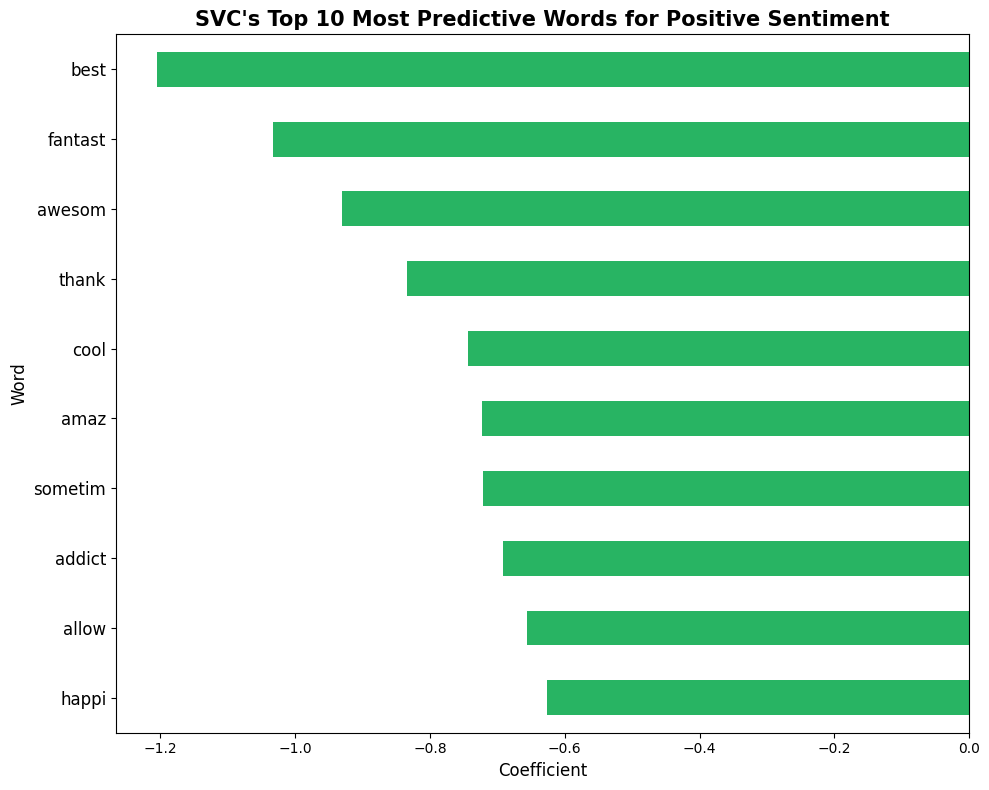

In [97]:
pos_sent_svc.sort_values('feature_importance', ascending=False).plot(x='word', y='feature_importance', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("SVC's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

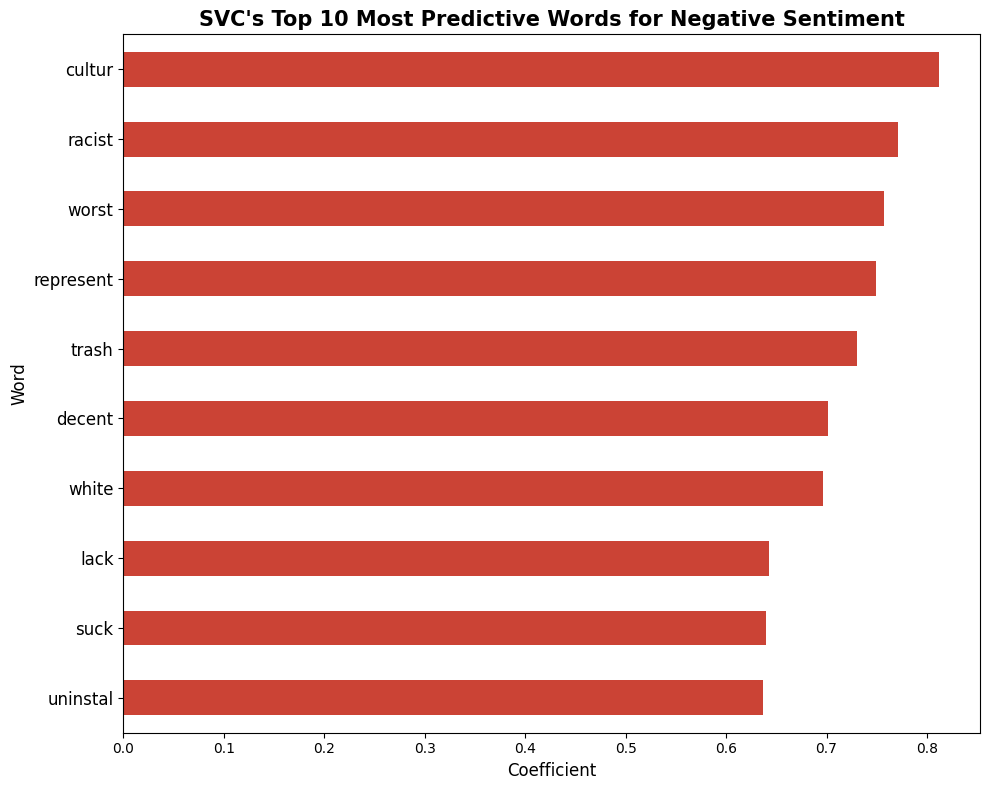

In [98]:
neg_sent_svc.plot(x='word', y='feature_importance', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("SVC's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

Thus, SVC indicates that the words 'fantast', 'addict' and 'happi' are related to positive sentiments. On the other hand, words like 'uninstal', 'suck' and 'worst' are closely associated to negative reviews.

Very interestingly, a lot of words related to ethnicity/race e.g., 'white', 'racist', 'represent' and 'cultur'. Much like our analysis in our [exploratory data analysis](https://github.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker/blob/master/notebooks/02_eda_and_preprocessing.ipynb), these set of complaints likely reference the Natlan update (the most recently released region as of 3rd November 2024). While drawing inspiration from Mesoamerican cultures and Native American cultures, the majority of characters are rather light-skinned contrary to their real life origins. Thus, this is something Hoyoverse should keep in mind when releasing new characters.

##### 2.2 Misclassified Reviews on Validation Set

Let's have a look at the misclassified reviews to understand the limitations in our SVC model.

In [99]:
# create a copy of the `reviews_val` dataframe to not alter the original one.
reviews_val_svc = reviews_val.copy()

In [100]:
reviews_val_svc.shape

(6472, 4)

In [101]:
# run inference
reviews_val_svc['pred'] = reviews_val_svc['content_stem'].map(lambda x: svc_model.predict([x])[0])

In [102]:
reviews_val_svc.head(3)

,content,content_stem,score,target,pred
0,"My game was great! I play it on the pc too! But since the recent update, the game does not work on my phone. I have a Samsung s10e. It worked flawlessly before but it keeps getting stuck on the loading screen then crashing. I've cleared the cache, date, and completely reinstalled the game and it DID NOT fix the issue. Please fix soon! I'm missing out on daily quests due to not always being home on my computer, but I always have my phone with me.",pc sinc recent updat work phone samsung e work flawlessli keep get stuck load screen crash clear cach date complet reinstal fix issu pleas fix soon miss daili quest due alway home comput alway phone,3,1,1
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1,0
2,Your game is great I like the way you can tell which region based on buy I don't like how you use a real people and white wash them.,way tell region base buy use real peopl white wash,2,1,1


In [103]:
# Create a column to indicate if the review was correctly predicted
reviews_val_svc['correctly_classified'] = (reviews_val_svc['pred'] == reviews_val_svc['target'])

In [104]:
# 1369 misclassified reviews
reviews_val_svc[reviews_val_svc['correctly_classified']==0].shape

(1369, 6)

In [105]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
reviews_val_svc[(reviews_val_svc['target']==0) & (reviews_val_svc['pred']==1)][['content','content_stem','score','target','pred']].head(20)

,content,content_stem,score,target,pred
7,"Surprisingly charming so far, and the combat feels natural. Would give it a higher rating, but the Android app has an audio bug - crackling begins after 15+ minutes of play, and gets gradually worse. Restarting the app fixes the issue for the next 15 minutes. I look forward to trying it on PC!",surprisingli charm far combat feel natur would give higher rate android app audio bug crackl begin minut get gradual wors restart app fix issu next minut look forward tri pc,4,0,1
23,"This game is great, don't get me wrong- but the developers are not it. Learn to actually compensate your players, and maybe actually listen to them. New artifacts loadouts? No one asked for the system you've decided to implement, as it's just a fast equip feature with extra steps, rather than an actual ""loadout"".",get wrong develop learn actual compens player mayb actual listen new artifact loadout one ask system decid implement fast equip featur extra step rather actual loadout,5,0,1
50,"I am only a rank 8 adventurer on mobile, but.. Positive: nothing hinders your exploration, except stimina deletion on climb/swim. Doable. Smooth combat, No pay to play elements slow you from playing as long as you want, no tiny backpacks, quality voice acting, this is fun and gorgeous. Negative: only on mobile, the free ranged camera makes it hard to judge combat positioning for male protag. + Yes, there is auto lock on at the general direction you are facing.",rank adventur mobil posit noth hinder explor except stimina delet climb swim doabl smooth combat pay element slow long tini backpack qualiti voic act gorgeou neg mobil free rang camera make hard judg combat posit male protag ye auto lock gener direct face,4,0,1
52,"The game is very good and all but there's one problem with the new character, Mualani, whenever I'd jump a small height like bounce on the mushrooms on sumeru, she'd take lot of damage only by jumping on them.",one problem new mualani whenev jump small height bounc mushroom sumeru damag jump,4,0,1
53,"Since the Natlan update I've been totally back in my Genshin phase, it offers fun game mechanics and good rewards, the only reason I'm giving it 4 stars is because I feel like even tho they added the Imaginary theater the game still lacks a bit of endgame-content. Especially after changing the abyss reset to 1 month, I finish all the floor in less than a day and then have to wait again for a month.. I think just reverting it back to how it's used to be would be a good move",sinc natlan updat total back phase offer mechan reward reason give star tho ad imaginari theater lack bit endgam content especi chang abyss reset month finish floor less day wait month think revert back use would move,4,0,1
54,"My phone can't handle natlan,however this game will still be peak!",phone handl natlan howev peak,4,0,1
72,Best Open World Gacha I've played and HoYo has it mapped out for several more years. Major updates every 6 weeks. Poor reviews are mostly storage space (get a phone from this decade) or salty gamblers (GI has a great Pity system.) if you think you've explored an area 100% there's still dozens of hidden chests and quests and the map is HUGE and still growing. The rating went down awhile back due to a nerf - that was reversed. Bunch of children. And the QoL upgrades are A+ each new patch. F2P too.,best open world gacha hoyo map sever year major updat everi week poor review mostli storag space get phone decad salti gambler gi piti system think explor area dozen hidden chest quest map huge grow rate went awhil back due nerf revers bunch children qol upgrad new patch f p,5,0,1
77,"This is a great game! I love it. I only reccomend to people who play on devices with loads of storage as this game takes up alot of it. (On phone it may overheat, be careful) As a console and mobile player, i have no complaints as graphics are great, characters are great and everything else is excellent. However, a lack of cultural inclusion w

In [106]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
reviews_val_svc[(reviews_val_svc['target']==1) & (reviews_val_svc['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1,0
22,"There's a lot of quality of life changes that should be made. 5 Weekly bosses that have resin cost is pretty weak as well. Advancing in Adventure Rank is pretty inconsequential as well beyond a certain point. The 1 year if it was a standard banner character, or weapon choice for everyone beyond AR 15-20 or something would've been amazing and wouldn't have resulted in going from a 4.5 star game down to 2 stars now. The new anniversary rewards are a nice start.",qualiti life chang made weekli boss resin cost pretti weak well advanc adventur rank pretti inconsequenti well beyond certain point year standard banner weapon choic everyon beyond ar someth would amaz result go star star new anniversari reward nice start,2,1,0
28,"Although I didn't make it too far into the game, the graphics are amazing. Sadly, my phone isn't exactly compatible for the amount of storage it takes up and even when I had the space, it took about an hour to load. I hoping that it would be a one time thing but I guess not. Overall, if you have a compatible device I would most definently recommend.",although far graphic amaz sadli phone exactli compat amount storag take space took hour load hope would one time thing guess overal compat devic would defin recommend,3,1,0
37,The unexpected storyline was amazing can't wait to see more and this game have been very kind to me for giving out lots of 5* character<3 Edited: Skip button please.,unexpect storylin amaz wait see kind give lot edit skip button pleas,3,1,0
43,"Genshin is a love-hate relationship. The graphics, mechanics, and general story lines are lovely, as are the special events. However, the reward structure in terms of in-game currency makes it the most expensive gotcha-game on the market. I've played amazing games I don't live up to all again impact can offer but they were far better at rewarding its player base, especially those who pay for in game currency. I play this mainly on PS5 and will be taking a long break to explore other games.",hate relationship graphic mechan gener line love special event howev reward structur term currenc make expens gotcha market amaz game live impact offer far better reward base especi pay currenc mainli ps take long break explor game,3,1,0
...,...,...,...,...,...
6386,"Thank you for the experience. I enjoyed the game initially, but I encountered persistent lag issues during solo dungeons, even with a high-end device and the lowest graphic settings. As an MMORPG enthusiast, I appreciated the game, but the gacha system and its costs made it less appealing, especially compared to other games that avoid excessive monetization. I’m grateful for the time I spent playing. If there were a significant incentive beyond 500 Primogems and improvements to the lag issues..",thank experi enjoy initi encount persist lag issu solo dungeon high end devic lowest graphic set mmorpg enthusiast appreci gacha system cost made less appeal especi compar game avoid excess monet grate time spent signific incent beyond primogem improv lag issu,2,1,0
6404,Nice game but we can only play mission when we increase the Adventure rank which is too much thats why I uninstalled the game,nice mission increas adventur rank that uninstal,3,1,0
6414,"Genshin Impact is amazing, the graphics are nice, and the overall idea of the game is interesting. Although I love the game, I have to say that it's storyline is falling off, this game had been one of my favorites until Inuzuma was unlocked, Inuzuma felt rushed and the events have gotten very boring, the 4 stars of genshin after Inuzuma was released also fell off, the designs of Inuzuma and it's characters are great, but they're boring. Overall though, I really enjoyed this game.",impact amaz graphic nice overal idea interest although say storylin 

Now, that we have looked through samples of the false positives and false negatives. We will identify the top most frequently occuring words to explain the misclassifications.